In [5]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt

In [6]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [7]:
# Directory where the DICOM files are being stored (in this
# case the 'MyHead' folder). 
pathDicom = "./Head/"

# Z slice of the DICOM files to process. In the interest of
# simplicity, segmentation will be limited to a single 2D
# image but all processes are entirely applicable to the 3D image
idxSlice = 50

# int labels to assign to the segmented white and gray matter.
# These need to be different integers but their values themselves
# don't matter
labelWhiteMatter = 1
labelGrayMatter = 2

In [8]:
reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(pathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

In [9]:
imgOriginal = imgOriginal[:,:,idxSlice]

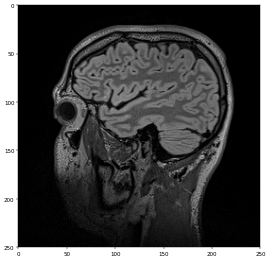

In [10]:
sitk_show(imgOriginal)

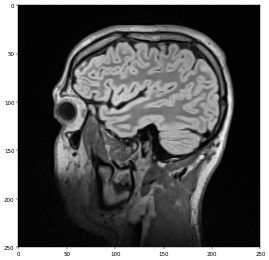

In [11]:
imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgOriginal)

sitk_show(imgSmooth)

In [12]:
lstSeeds = [(150,75)]

imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                              seedList=lstSeeds, 
                                              lower=130, 
                                              upper=190,
                                              replaceValue=labelWhiteMatter)

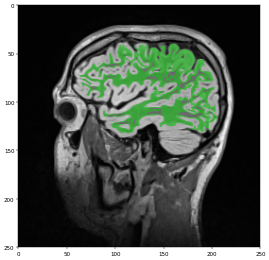

In [13]:
# Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

# Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

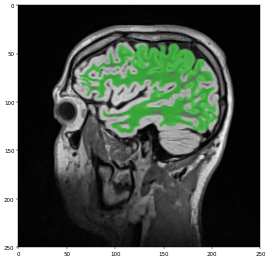

In [14]:
imgWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgWhiteMatter,
                                                          radius=[2]*3,
                                                          majorityThreshold=1,
                                                          backgroundValue=0,
                                                          foregroundValue=labelWhiteMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles))

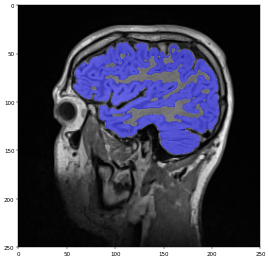

In [15]:
lstSeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]

imgGrayMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                             seedList=lstSeeds, 
                                             lower=150, 
                                             upper=270,
                                             replaceValue=labelGrayMatter)

imgGrayMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imgGrayMatter,
                                                         radius=[2]*3,
                                                         majorityThreshold=1,
                                                         backgroundValue=0,
                                                         foregroundValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgGrayMatterNoHoles))

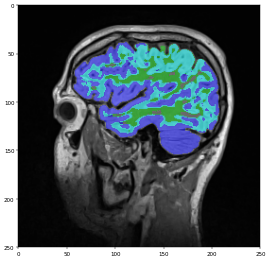

In [16]:
imgLabels = imgWhiteMatterNoHoles | imgGrayMatterNoHoles


sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

In [37]:
imgGrayMatterNoHoles.GetNumberOfComponentsPerPixel()

1

In [19]:
SimpleITK.GetArrayFromImage(imgWhiteMatterNoHoles).min()

0

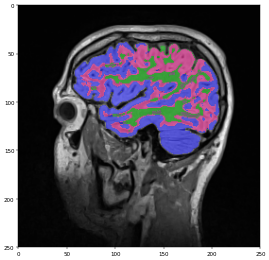

In [20]:
# imgMask= imgWhiteMatterNoHoles/labelWhiteMatter * imgGrayMatterNoHoles/labelGrayMatter
imgMask= imgWhiteMatterNoHoles * imgGrayMatterNoHoles
imgWhiteMatterNoHoles -= 1000*imgMask*labelWhiteMatter

imgLabels = imgWhiteMatterNoHoles + imgGrayMatterNoHoles

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels))

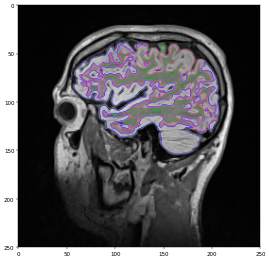

In [21]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, SimpleITK.LabelContour(imgLabels)))